In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPModel

In [2]:
data_dir = "data"
dataset_id = "20220329222400"

dataset_dir = os.path.join(data_dir, dataset_id)

assert os.path.exists(dataset_dir), "Dataset directory does not exist"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# read embeds, prices, and ids
input_ids = np.load(os.path.join(dataset_dir, "input_ids.npy"))
attention_mask = np.load(os.path.join(dataset_dir, "attention_mask.npy"))
pixel_values = np.load(os.path.join(dataset_dir, "pixel_values.npy"))


prices = np.load(os.path.join(dataset_dir, "prices.npy"))

idx = np.where(prices < 800)[0]

input_ids = input_ids[idx]
attention_mask = attention_mask[idx]
pixel_values = pixel_values[idx]
prices = prices[idx]

# normalize prices
mean_price = np.mean(prices)
std_price = np.std(prices)
prices = (prices - mean_price) / std_price

prices = torch.tensor(prices, dtype=torch.float32).unsqueeze(dim=1)

ids = np.load(os.path.join(dataset_dir, "ids.npy"))


(934, 77)
torch.Size([934, 1])


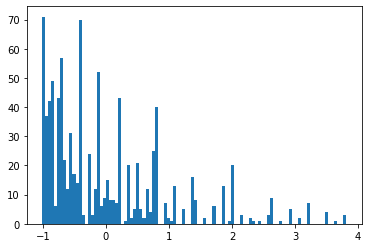

In [4]:
print(input_ids.shape)
print(prices.shape)

# histogram of prices
plt.hist(prices.numpy(), bins=100)
plt.show()

In [5]:
class PriceModelV2(nn.Module):

    def __init__(self):
        super(PriceModelV2, self).__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.linear = nn.Linear(1024, 1)

    def forward(self, inputs):
        clip_output = self.clip(**inputs)
        text_embeds = clip_output.text_embeds
        image_embeds = clip_output.image_embeds
        # concatenate text and image embeddings
        x = torch.cat([text_embeds, image_embeds], dim=1)
        x = self.linear(x)
        return x

class ClipInputDataset(Dataset):
    def __init__(self, input_ids, attention_mask, pixel_values, prices, device):
        # put input_ids on device
        self.input_ids = torch.tensor(input_ids, dtype=torch.int).to(device)
        self.attention_mask = torch.tensor(attention_mask, dtype=torch.int).to(device)
        self.pixel_values = torch.tensor(pixel_values, dtype=torch.float32).to(device)
        self.prices = torch.tensor(prices, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.prices)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "pixel_values": self.pixel_values[idx],
        }, self.prices[idx]

In [6]:
train_p, valid_p, test_p = 0.6, 0.2, 0.2

assert train_p + valid_p + test_p == 1, "Train, valid, and test percentages must add up to 1."

n_train = int(len(prices) * train_p)
n_valid = int(len(prices) * valid_p)
n_test = len(prices) - n_train - n_valid

training_data = ClipInputDataset(
    input_ids[:n_train],
    attention_mask[:n_train],
    pixel_values[:n_train],
    prices[:n_train],
    device
)
validation_data = ClipInputDataset(
    input_ids[n_train:n_train + n_valid],
    attention_mask[n_train:n_train + n_valid],
    pixel_values[n_train:n_train + n_valid],
    prices[n_train:n_train + n_valid],
    device
)
test_data = ClipInputDataset(
    input_ids[n_train + n_valid:],
    attention_mask[n_train + n_valid:],
    pixel_values[n_train + n_valid:],
    prices[n_train + n_valid:],
    device
)



AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
epochs = 10
batch_size = 32
learning_rate = 1e-5

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

model = PriceModelV2().to(device)
optimzer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [ ]:
loss_history = []
val_loss_history = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    pbar = tqdm(train_dataloader)
    total_loss = 0
    count = 0

    total_val_loss = 0
    for x, y in pbar:
        model.train()
        preds = model(x)
        output = loss(preds, y)

        optimzer.zero_grad()
        output.backward()
        optimzer.step()

        total_loss += output.item()
        count += 1

    loss_history.append(total_loss / count)

    count = 0
    with torch.no_grad():

        for x, y in valid_dataloader:
            model.eval()
            preds = model(x)
            output = loss(preds, y)

            total_val_loss += output.item()
            count += 1
        
        val_loss_history.append(total_val_loss / count)

    print(f"Training loss: {loss_history[-1]}")
    print(f"Validation loss: {val_loss_history[-1]}")

# plot loss
plt.plot(loss_history)
plt.plot(val_loss_history)
# add title and labels
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# add a legend
plt.legend(["Training Loss", "Validation Loss"])
# save figure
plt.savefig(os.path.join(dataset_dir, "loss.png"))
plt.show()


In [ ]:
def scatter_predict_vs_actual_data(model, dataloader):
    # predict prices on validation set
    all_preds = []
    all_prices = []
    with torch.no_grad():
        for x, y in dataloader:
            model.eval()
            preds = model(x) # (batch_size, 1)
            all_preds.append(preds.numpy())
            all_prices.append(y.numpy())

    # flatten lists
    all_preds = np.concatenate(all_preds)
    all_prices = np.concatenate(all_prices)

    # un normalize prices
    all_prices = (all_prices * std_price) + mean_price
    all_preds = (all_preds * std_price) + mean_price

    return all_prices, all_preds



train_actual, train_preds = scatter_predict_vs_actual_data(model, train_dataloader)
valid_actual, valid_preds = scatter_predict_vs_actual_data(model, valid_dataloader)

In [ ]:
def scatter_predict_vs_actual_plot(all_prices, all_preds, name):
    # Scatter plot of predicted prices vs actual prices
    plt.scatter(all_prices, all_preds)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Predicted vs Actual Price")
    # make axis the same scale
    global_min = min(all_prices.min(), all_preds.min())
    global_max = max(all_prices.max(), all_preds.max())
    # global_max = 1000
    plt.xlim(global_min, global_max)
    plt.ylim(global_min, global_max)
    # save figure without transparent background
    plt.savefig(os.path.join(dataset_dir, f"{name}_scatter_predict_vs_actual.png"), transparent=False)
    plt.show()
    
scatter_predict_vs_actual_plot(train_actual, train_preds, "train")
scatter_predict_vs_actual_plot(valid_actual, valid_preds, "valid")